## Examples for OptPulseProcessor / Примеры для OptPulseProcessor

In [2]:
from numpy import pi
from qutip.qip.device import OptPulseProcessor
from qutip.qip.circuit import QubitCircuit
from qutip.qip.operations import expand_operator, toffoli
from qutip.operators import sigmaz, sigmax, identity
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.tensor import tensor

The qutip.OptPulseProcessor is a noisy quantum device simulator integrated with the optimal pulse algorithm from the qutip.control module. It is a subclass of qutip.Processor and is equipped with a method to find the optimal pulse sequence (hence the name OptPulseProcessor) for a qutip.QubitCircuit or a list of qutip.Qobj. For the user guide of qutip.Processor, please refer to the introductory notebook (https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/qip-noisy-device-simulator.ipynb).

Qutip.OptPulseProcessor - это симулятор квантового устройства с шумом, интегрированный с оптимальным алгоритмом импульсов из модуля qutip.control. Он является подклассом qutip.Processor и оснащен методом поиска оптимальной последовательности импульсов (отсюда и название OptPulseProcessor) для qutip.QubitCircuit или списка qutip.Qobj. Руководство пользователя qutip.Processor можно найти в https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/qip-noisy-device-simulator.ipynb



## Single-qubit gate / Однокубитовый вентиль

Like in the parent class Processor, we need to first define the available Hamiltonians in the system. The OptPulseProcessor has one more parameter, the drift Hamiltonian, which has no time-dependent coefficients and thus won't be optimized.

Как и в родительском классе Processor, нам нужно сначала определить доступные гамильтонианы в системе. У OptPulseProcessor есть еще один параметр, гамильтониан дрейфа, который не имеет зависящих от времени коэффициентов и поэтому не будет оптимизирован.

In [3]:
N = 1
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = sigmax()
processor = OptPulseProcessor(N, drift=H_d)
processor.add_control(H_c, 0)


The method load_circuit calls qutip.control.optimize_pulse_unitary and returns the pulse coefficients.

Метод load_circuit вызывает qutip.control.optimize_pulse_unitary и возвращает коэффициенты импульса.

********** Gate 0 **********
Final fidelity error 9.77051772821369e-12
Final gradient normal 1.5634618862956533e-05
Terminated due to Goal achieved
Number of iterations 11


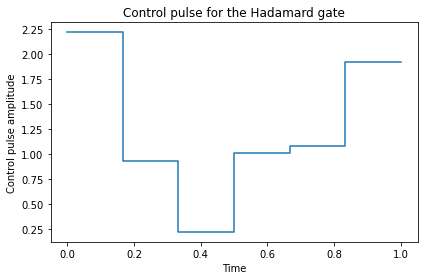

In [4]:
qc = QubitCircuit(N)
qc.add_gate("SNOT", 0)

# This method calls optimize_pulse_unitary
tlist, coeffs = processor.load_circuit(qc, min_grad=1e-20, init_pulse_type='RND',
                                       num_tslots=6, evo_time=1, verbose=True)
processor.plot_pulses(title="Control pulse for the Hadamard gate");

Like the Processor, the simulation is calculated with a QuTiP solver. The method run_state calls mesolve and returns the result. One can also add noise to observe the change in the fidelity, e.g. the t1 decoherence time.

Как и в случае с процессором, моделирование рассчитывается с помощью решателя QuTiP. Метод run_state вызывает mesolve и возвращает результат. Также можно добавить шум, чтобы наблюдать изменение верности, например время декогеренции t1.

In [5]:
rho0 = basis(2,1)
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
result = processor.run_state(init_state=rho0)
print("Fidelity:", fidelity(result.states[-1], minus))

# add noise
processor.t1 = 40.0
result = processor.run_state(init_state=rho0)
print("Fidelity with qubit relaxation:", fidelity(result.states[-1], minus))

Fidelity: 1.0000000074365047
Fidelity with qubit relaxation: 0.993364398820646


## Multi-qubit gate / Многокубитовый вентиль

In the following example, we use OptPulseProcessor to find the optimal control pulse of a multi-qubit circuit. For simplicity, the circuit contains only one Toffoli gate.

В следующем примере мы используем OptPulseProcessor, чтобы найти оптимальный управляющий импульс многокубитовой схемы. Для простоты схема содержит только один вентиль Тоффоли.

In [7]:
toffoli()

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

We have single-qubit control σx and σz , with the argument cyclic_permutation=True, it creates 3 operators each targeted on one qubit.

У нас есть однокубитное управление σx и σz с аргументом cyclic_permutation = True он создает 3 оператора, каждый нацеленный на один кубит.

In [8]:
N = 3
H_d = tensor([identity(2)] * 3)
test_processor = OptPulseProcessor(N, H_d, [])
test_processor.add_control(sigmaz(), cyclic_permutation=True)
test_processor.add_control(sigmax(), cyclic_permutation=True)


The interaction is generated by σxσx between the qubit 0 & 1 and qubit 1 & 2. expand_operator can be used to expand the operator to a larger dimension with given target qubits.

Взаимодействие порождается σxσx
 между кубитами 0 и 1 и кубитами 1 и 2. expand_operator можно использовать для расширения оператора до большего измерения с заданными целевыми кубитами.

In [9]:
sxsx = tensor([sigmax(),sigmax()])
sxsx01 = expand_operator(sxsx, N=3, targets=[0,1])
sxsx12 = expand_operator(sxsx, N=3, targets=[1,2])
test_processor.add_control(sxsx01)
test_processor.add_control(sxsx12)

Use the above defined control Hamiltonians, we now find the optimal pulse for the Toffoli gate with 6 time slots. Instead of a QubitCircuit, a list of operators can also be given as an input. Different color in the figure represents different control pulses.


Используя определенные выше гамильтонианы управления, мы теперь находим оптимальный импульс для ворот Тоффоли с 6 временными интервалами. Вместо QubitCircuit в качестве входных данных также может быть указан список операторов. Разным цветом на рисунке представлены разные управляющие импульсы.

********** Gate 0 **********
Final fidelity error 0.0761217257501332
Final gradient normal 7.002339040021171e-06
Terminated due to function converged
Number of iterations 458


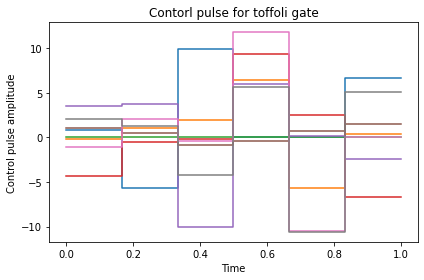

In [10]:
test_processor.load_circuit([toffoli()], num_tslots=6, evo_time=1, verbose=True);

test_processor.plot_pulses(title="Contorl pulse for toffoli gate");

## Merging a quantum circuit / Слияние квантовой схемы

If there are multiple gates in the circuit, we can choose if we want to first merge them and then find the pulse for the merged unitary.

Если в схеме несколько вентилей, мы можем выбрать, хотим ли мы сначала объединить их, а затем найти импульс для объединенной унитарной системы.

In [11]:
qc = QubitCircuit(N=3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)

********** Gate 0 **********
Final fidelity error 9.007477753675275e-07
Final gradient normal 7.954144790388377e-05
Terminated due to function converged
Number of iterations 219
********** Gate 1 **********
Final fidelity error 1.1190881554767884e-10
Final gradient normal 1.0258652673719492e-05
Terminated due to function converged
Number of iterations 10
********** Gate 2 **********
Final fidelity error 3.280761218249495e-10
Final gradient normal 1.1804873264678057e-05
Terminated due to function converged
Number of iterations 28


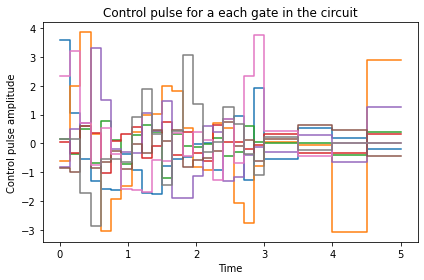

In [12]:
setting_args = {"CNOT": {"num_tslots": 20, "evo_time": 3},
                "RX": {"num_tslots": 2, "evo_time": 1},
                "RY": {"num_tslots": 2, "evo_time": 1}}

test_processor.load_circuit(qc, merge_gates=False, setting_args=setting_args, verbose=True);
test_processor.plot_pulses(title="Control pulse for a each gate in the circuit");

In the above figure, the pulses from t=0 to t=3 are for the CNOT gate while the rest for are the two single qubits gates. The difference in the frequency of change is merely a result of our choice of evo_time. Here we can see that the three gates are carried out in sequence.

На приведенном выше рисунке импульсы от t = 0
 к t = 3
 предназначены для ворот CNOT, а остальные - для двух отдельных кубитов. Разница в частоте изменений - это просто результат нашего выбора evo_time. Здесь мы видим, что три ворот выполняются последовательно.

********** Gate 0 **********
Final fidelity error 5.724183691491191e-07
Final gradient normal 8.696327545561616e-05
Terminated due to function converged
Number of iterations 291


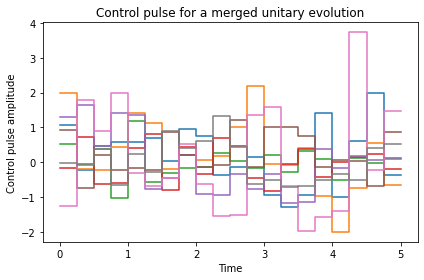

In [13]:
qc = QubitCircuit(N=3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)
test_processor.load_circuit(qc, merge_gates=True, verbose=True, num_tslots=20, evo_time=5);
test_processor.plot_pulses(title="Control pulse for a merged unitary evolution");

In this figure there are no different stages, the three gates are first merged and then the algorithm finds the optimal pulse for the resulting unitary evolution.


На этом рисунке нет разных этапов, сначала объединяются три логических элемента, а затем алгоритм находит оптимальный импульс для результирующей унитарной эволюции.

In [14]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.18.5
SciPy,1.5.0
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,6
BLAS Info,INTEL MKL
IPython,7.16.1
Python,"3.8.3 (default, Jul 2 2020, 11:26:31) [Clang 10.0.0 ]"
OS,posix [darwin]
